# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [88]:
# import libraries
from pyspark.sql import SparkSession

In [89]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce

In [90]:
#ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [91]:
#To load saved models
from pyspark.ml.tuning import CrossValidatorModel as mlm

In [92]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# 项目定义
### 1. 项目概况
》Sparkify是Udacity数据科学家纳米学位毕业项目提供的的一个虚构的音乐流应用程序;它提供付费和免费的音乐服务，客户可以在两种服务之间切换，并且他们可以随时取消订阅。

》给定的客户数据集是有12GB，因此标准的分析和机器学习工具在这里无法使用，因为它将不适合计算机的内存（数据分析和建模需要占用超过32GB甚至更多计算机的内存，会使得单机系统奔溃）。

》执行这种分析的安全方法是使用大数据工具，如Apache Spark，这是最快的大数据工具之一。

》为本项目提供了小型、中型和大型的三种尺寸的数据集。我选择使用了小型尺寸的数据集，以便在本地单机上处理。

### 2.问题陈述
本项目的目标是要创建一个机器学习模型在这之前预测用户取消订阅的意图（称为客户流失）。

解决问题思路：

1.数据处理：这部分我们将数据进行预处理为后续分析和建模打好基础，包含：1）数据集清洗和缺失值处理 2）EDA 3)特征工程处理

2.建立模型：这部分致力于利用机器学习在选定特征变量的基础上，预测用户取消订阅的意图；利用处理后数据集进行不同机器学习模型训练和评价

3.生成应用：将之前两部分的内容进行打包和整理，最终生成一个应用程序；并介绍使用的原理和方法

### 3.评价指标
混淆矩阵，F1分数，AUC作为判断标准：

1)混淆矩阵

①　本身是好客户，判断也为好客户的人群数量，英文标记为TP：True Positive

②　本身是坏客户，判断也为坏客户的人群数量，英文标记为TN：True Negative

③　本身是好客户，却判断为坏客户的人群数量，即误杀掉的，英文标记为FN：False Negative

④　本来是坏客户，却判断成好客户的人群数量，即漏网之鱼，英文标记为FP： False Positive

precision = TP / (TP + FP)   
recall = TP / (TP + FN)      
accuracy = (TP + TN) / (P + N)

2)F1分数
F1分数（F1 Score），是统计学中用来衡量二分类模型精确度的一种指标。它同时兼顾了分类模型的精确率和召回率。F1分数可以看作是模型精确率和召回率的一种调和平均，它的最大值是1，最小值是0

F1-score = 2 / [(1 / precision) + (1 / recall)]

3)AUC

ROC 曲线
横坐标是假正率，纵坐标是真正率.roc曲线尽可能的靠近左上边(0,1)的位置，效果越好 (0,0):真正率和假正率都是0，所有样本全部预测为负样本 (1,1):真正率和假正率都是1，所有样本全部预测为正样本 (0,1):真正率为1，假正率为0，正样本全部预测正确，负样本全部预测正确最完美的 情况

(1,0):真正率为0，假正率为1，正样本全部预测错误，负样本全部预测正确

AUC曲线
ROC曲线下的面积，常介于0.5和1之间(极端情况下低于0.5)，可以直观的评价分类器的好坏，值越大越好。

AUC值是一个概率值，当你随机挑选一个坏样本以及好样本，当前的分类算法根据计算得到的概率值将这个坏样本排在好样本前面的概率就是AUC值，AUC值越大，当前分类算法越有可能将坏样本排在好样本前面，从而能够更好地分类。

AUC的常用阈值 >0.7;有很强的区分度 0.6~0.7;有一定的区分度 0.5~0.6,有较弱的区分度;低于0.5,区分度弱于随机猜测

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [95]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
#see the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [96]:
#Tabulated head through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [97]:
#To know nulls
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [100]:
dfp.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [99]:
dfp.isnull().sum()/286500

artist           0.203812
auth             0.000000
firstName        0.029131
gender           0.029131
itemInSession    0.000000
lastName         0.029131
length           0.203812
level            0.000000
location         0.029131
method           0.000000
page             0.000000
registration     0.029131
sessionId        0.000000
song             0.203812
status           0.000000
ts               0.000000
userAgent        0.029131
userId           0.000000
dtype: float64

In [102]:
dfp.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [80]:
dfp[dfp.userId == '']['userId'].count()

8346

In [81]:
df.filter(df.sessionId == '').count()

0

In [82]:
#Dropping the missing User's ID rows
df = df.filter(df.userId != '')
#Double-Check,SHOULD be 0
df.filter(df.userId == '').count()

0

In [83]:
#Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F', None], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object))

In [84]:
dfp.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [85]:
# Definig user functions to get hour, day, month, and weekday of cancellation
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))
    print(f'Column {label} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [63]:
#Let's know the number of users in this dataset and number of pages and sessions
[f'Unique {col}s: {df.select(col).dropDuplicates().count()}'for col in ('userId', 'page', 'sessionId')]

['Unique userIds: 225', 'Unique pages: 19', 'Unique sessionIds: 2312']

In [64]:
#How many users in the dataset?
df.select('userId').dropDuplicates().count()

225

In [65]:
#Tabulated head through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,hour,day,month,week_day
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1,10,1
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,1,10,1
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1,10,1
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,1,10,1
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1,10,1


**数据集评估：**

1.该数据集共有286500条记录，每条记录有18列特征，其中6列为数据值型变量；其余为类别特征变量

2.在18个特征中，有9个包含缺失值；包含有完整信息的 特征变量是auth, itemInSession, level, method, page, sessionId, status, ts 和 userId

3.ts和registration特征的数据类型应该为时间数据，status的数据类型应该为类别数据，需要修改和更正

4.location特征中包含了州和市，可进行拆分；userAgent特征中包含了操作系统、浏览器等信息，可以进一步拆分

5.数据集中涉及的去重后UserId 225个，页面19个， sessionId2312个

6.日志的日期范围从2018年10月到2018年12月

**预处理小结：**

1.在18个特征中，有9个包含缺失值；由于缺失率未超过30%的变量因此不进行删除

2.ts和registration特征的数据类型应该为时间数据，通过函数获取，得到相应的月份、日度和小时数据

3.location特征中包含了州和市，可进行拆分；userAgent特征中包含了操作系统、浏览器等信息，可以进一步拆分（在EDA中有进一步拆分，此处先不进行处理）

4.针对userId的数据，通过以下处理回答，项目提示中问题

**检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。**

*1)删除没有用户标识或会话标识的记录*

*2)使用命令dfs=df.dropna（how=“any”，subset=[“userId”，“sessionId”]）*

*3)从上表中我们注意到没有null userId或SessionId记录;然而应该检查空的Userid或SessionId*

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

In [18]:
#Churn is a label for user who cancelled so define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

#apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))

#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

#Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [19]:
#Again define pandas df for better view
dfp = df.toPandas()

In [21]:
dfp.sample(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
39410,The Killers,Logged In,Jeffery,M,33,Wheeler,197.25016,paid,"Bozeman, MT",PUT,NextSong,1533886191000,374,Somebody Told Me,200,1540382670000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",3,1
69021,Train,Logged In,Lindyn,F,50,Patel,205.45261,paid,"Truckee-Grass Valley, CA",PUT,NextSong,1532589384000,175,Marry Me,200,1539928939000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,300002,0
183970,Fergie,Logged In,Deegan,M,300,Robinson,396.12036,paid,"Hartford-West Hartford-East Hartford, CT",PUT,NextSong,1529252604000,1362,Wake Up,200,1541885278000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,33,0
102828,Arctic Monkeys,Logged In,Joshua,M,94,White,152.60689,paid,"San Antonio-New Braunfels, TX",PUT,NextSong,1528780738000,115,Baby I'm Yours,200,1539364747000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015,0
21588,The Killers,Logged In,Samuel,M,107,Wood,245.99465,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1537865819000,1305,Sam's Town,200,1540601836000,"""Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X...",138,0
4636,Primus,Logged In,Nicole,F,237,Beck,37.45914,paid,"Vineland-Bridgeton, NJ",PUT,NextSong,1532224335000,1799,Grandad's Little Ditty,200,1541938716000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124,0
2843,My Chemical Romance,Logged In,Nicole,F,163,Beck,208.16934,paid,"Vineland-Bridgeton, NJ",PUT,NextSong,1532224335000,1229,Headfirst For Halos,200,1540555711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124,0
269239,None,Logged In,Gregory,M,3,Jones,NaN,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,Thumbs Up,1538065863000,613,None,307,1539800038000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",76,0
115136,Dark Side Cowboys,Logged In,Bryson,M,361,Roberson,276.50567,paid,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1521380675000,1369,The Escape,200,1541131734000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",6,0
141083,None,Logged In,Justin,M,4,Schmidt,NaN,free,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1537915702000,964,None,200,1540462926000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",102,0


### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

### A.基础EDA分析

In [22]:
#Know number of users who remain and who canceled by pandas
dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [23]:
#by spark
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [24]:
#Exploring user status by gender
df.dropDuplicates(['userId','gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [25]:
#Exploring user status by paid and level
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



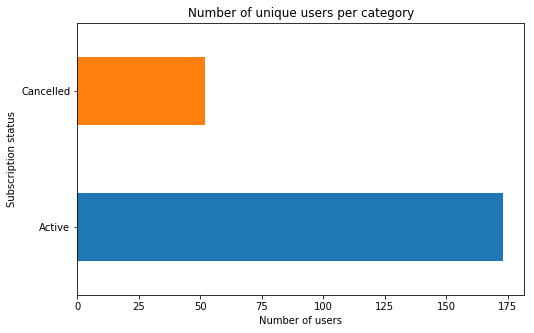

In [26]:
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(8,5),
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);

#Test
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

1.大概25%的用户属于取消类别（相对于活跃）。

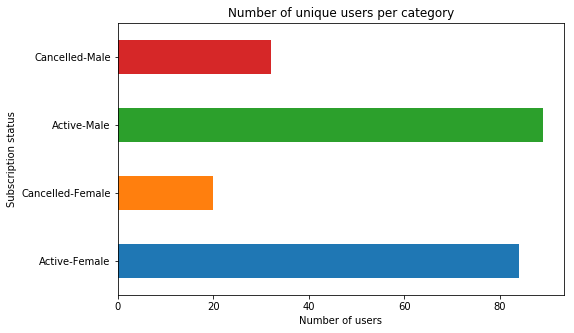

In [27]:
plot_frequency(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

2.活跃男性多于女性，取消男性也高于女性。与此同时，似乎男性比女性更倾向于取消。

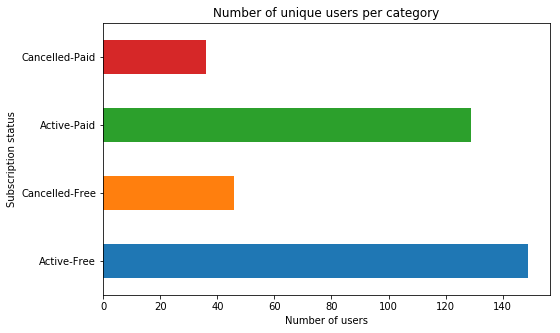

In [28]:
plot_frequency(['userId', 'level'],
               ['level', 'churn'],
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

3.免费用户略多于付费用户，取消的免费用户与取消的付费用户比例几乎相同。似乎付费/免费状态不影响帐户的终止。

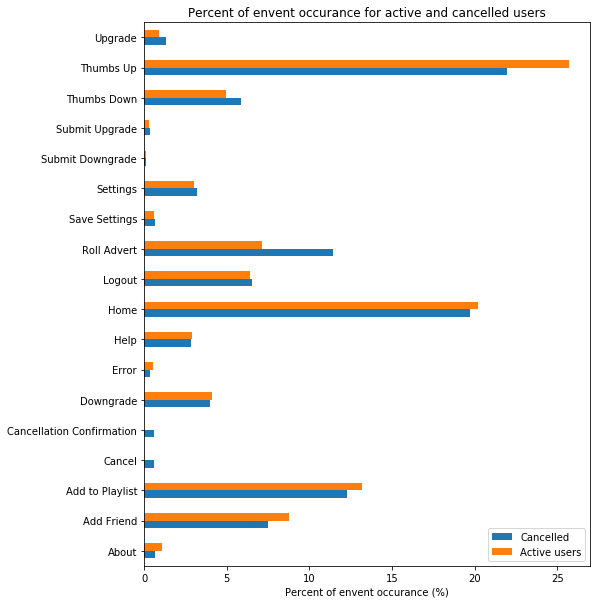

In [29]:
users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1/users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0/users_0.sum()*100

users_df = pd.DataFrame({'Cancelled': users_1, 'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of envent occurance (%)')
ax.set_title("Percent of envent occurance for active and cancelled users")
plt.show()

4.初步发现取消用户访问的最重要页面Roll Advert和Thumbs Down（与取消概率成正比），
而Thumbs Up,Add Friend和Add to Playlist是不取消帐户的好指标。

### B.时间序列分析

In [30]:
# Definig user functions to get hour, day, month, and weekday of cancellation

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [31]:
# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))
    print(f'Column {label} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [32]:
# to help in better plotting and visuals
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
152145,SKOLD vs. KMFDM,Logged In,Annabella,F,45,Knapp,254.43220,paid,"San Antonio-New Braunfels, TX",PUT,...,It's Not What,200,1540420602000,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,40,0,22,24,10,3
131720,Metallica,Logged In,Zoey,F,121,Floyd,515.21261,free,"Chicago-Naperville-Elgin, IL-IN-WI",PUT,...,Master Of Puppets,200,1543531801000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",200003,0,22,29,11,4
213373,Buddy Holly,Logged In,Cali,F,130,Brown,169.76934,paid,"Cleveland-Elyria, OH",PUT,...,True Love Ways,200,1539414405000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",100013,1,7,13,10,6
249492,Metallica,Logged In,Aron,M,2,Gardner,427.85914,free,"Portland-Vancouver-Hillsboro, OR-WA",PUT,...,The Unnamed Feeling,200,1543378064000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",200012,0,4,28,11,3
38418,Box Car Racer,Logged In,Christian,M,10,Robinson,260.10077,free,"Quincy, IL-MO",PUT,...,Cat Like Thief,200,1539314728000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",87,1,3,12,10,5


In [33]:
def get_series(col, churn, normalize=False):
    ''' 
    Get a series either of churn users or existing users
    THe function can normalize the series and return a percent value
    col: {str} the column to plot (hour, month, day, week_day)
    churn: {int} 0 or 1
    normalize: {bool} T/F, Default is False
    return a sorted pandas series
    '''
    ser1 = dfp[dfp.churn == churn].groupby([col])['userId'].count()
    try:
        ser1.index = ser1.index.astype(int)
    except:
        pass
    if normalize:
        ser1=ser1/ser1.sum()*100
    return ser1.sort_index()

In [34]:
def draw_time(col, normalize=True, figsize=(16,4), title=None, label_rotation=0):
    '''
    Draw a bar plot for churn and existing users based on 
         a specific column (hour, month, day, week_day)
         
    normalize: {bool} T/F, Default is True
    figsize: {tuple} the plot size, default is (16,4)
    title: descriptive title part
    Returns: None
    '''
    df_time = pd.DataFrame({'Cancelled': get_series(col, 1, normalize),
                            'Active users':get_series(col, 0, normalize)})
    ax = df_time.plot(kind='bar', figsize=figsize);
    ax.set_ylabel('Percent of users')
    if title is None:
        title = col
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

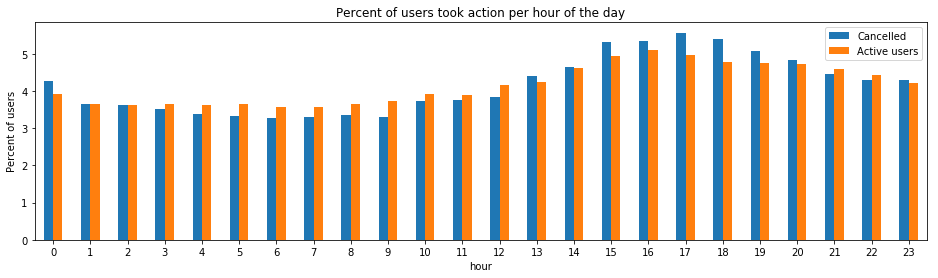

In [35]:
draw_time('hour', title='hour of the day');

5.根据一天中的小时数，活跃用户和取消用户之间似乎没有视觉效果差异。唯一的影响是，取消用户在13:00到20:00之间的时间内似乎更加活跃。

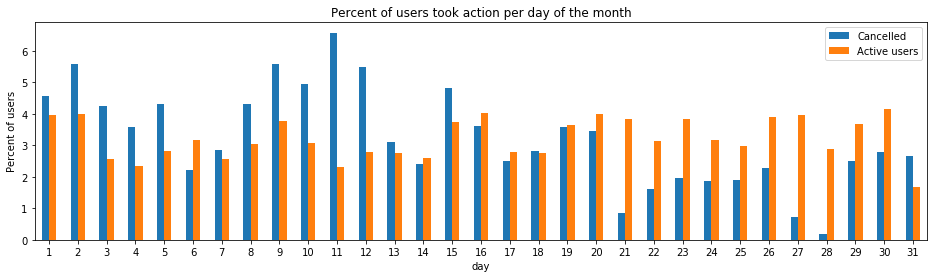

In [36]:
draw_time('day', title='day of the month');

6.取消用户在月底相对took action比例更高，可能是避免续费而注销的操作。

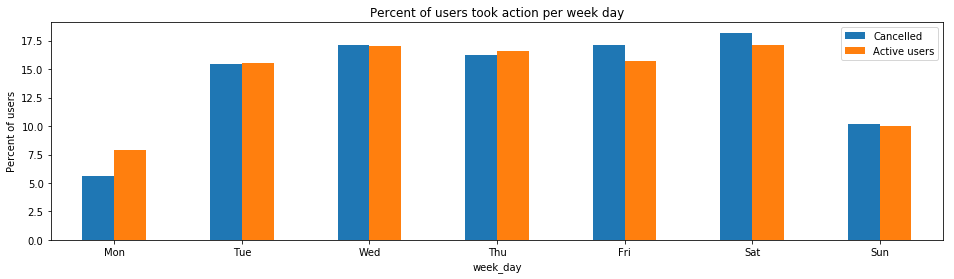

In [37]:
ax = draw_time('week_day', title='week day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0);

7.在星期五和星期六，取消用户took action比例更高，而活跃用户星期一took action比例更高。剩余的天数在两种用户类型之间没有明显的差异。

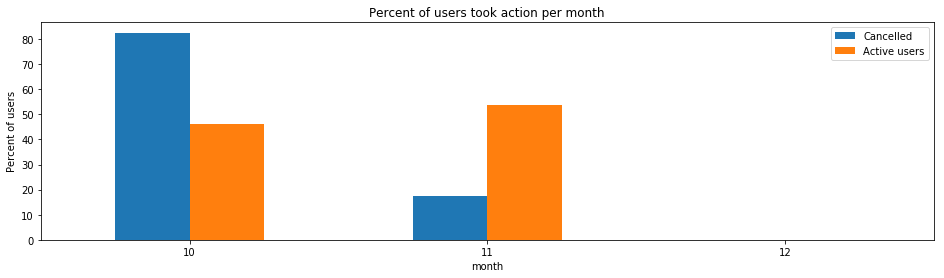

In [38]:
draw_time('month');

8.在拆分为月份情况，由于数据量相对较少，无法进行客观分析。

### C.分类特征分析

#### 1. 用户操作系统使用

In [39]:
dfp.userAgent.unique().shape[0]

56

In [40]:
agents = [x.strip() for x  in dfp.userAgent.unique()] 
# see sample
[agents[x] for x in [0, 2, 4, 10]]

['"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
 '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 '"Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53"']

In [41]:
# TO get the data between parenthesis
ex = '\(([^\)]*)\)'

# All OSs
sorted(list(set([re.findall(
    ex, x)[0].split(';')[0].capitalize(
) for x  in agents])))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [42]:
# Create mappers for the os
mapper_general = {'Compatible': 'Windows',  'Ipad': 'Mac',  'Iphone': 'Mac',  
          'Macintosh': 'Mac',  'Windows nt 5.1': 'Windows',  
          'Windows nt 6.0': 'Windows',  'Windows nt 6.1': 'Windows',  
          'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows',  
          'X11': 'Linux'}
mapper_specific = {'Compatible': 'Windows 7',  'Ipad': 'iPad',  'Iphone': 'iPhone',  
          'Macintosh': 'MacOS',  'Windows nt 5.1': 'Windows XP',  
          'Windows nt 6.0': 'Windows Vista',  'Windows nt 6.1': 'Windows 7',  
          'Windows nt 6.2': 'Windows 8.0',  'Windows nt 6.3': 'Windows 8.1',  
          'X11': 'Linux'}
print(sorted(list(set([mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))),
sorted(list(set([mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))))

['Linux', 'Mac', 'Windows'] ['Linux', 'MacOS', 'Windows 7', 'Windows 8.0', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'iPad', 'iPhone']


In [43]:
# Define user defined functions
os_general = udf(lambda x: mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_general", os_general(df.userAgent))

os_specific = udf(lambda x: mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_specific", os_specific(df.userAgent))

In [44]:
dfp.location.unique().shape[0]

114

In [45]:
states = set([state[1].strip() for state in [x.split(',') for x in dfp.location.unique()]])
len(states)

58

In [46]:
# Define a user defined function
get_state = udf(lambda x: x.split(',')[1].strip())
df = df.withColumn("state", get_state(df.location))

In [47]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', day='8', month='10', week_day='1', os_general='Mac', os_specific='iPhone', state='CT')]

In [48]:
# Convert to pandas for better visuals
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,userAgent,userId,churn,hour,day,month,week_day,os_general,os_specific,state
249278,Arctic Monkeys,Logged In,Payton,F,22,Campbell,199.36608,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39,0,8,27,11,2,Windows,Windows 7,CA
61137,Eisbrecher,Logged In,Jade,F,126,Stewart,241.89342,paid,"Cookeville, TN",PUT,...,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",300008,0,20,5,11,1,Mac,iPhone,TN
21775,Bobby Goldsboro,Logged In,Samuel,M,298,Wood,238.60200,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,"""Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X...",138,0,12,27,10,6,Mac,iPad,NY-NJ-PA
21618,Tiny Vipers,Logged In,Samuel,M,139,Wood,210.23302,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,"""Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X...",138,0,2,27,10,6,Mac,iPad,NY-NJ-PA
113829,Colbie Caillat,Logged In,Bryson,M,5,Roberson,216.31955,paid,"Houston-The Woodlands-Sugar Land, TX",PUT,...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",6,0,10,22,10,1,Mac,MacOS,TX


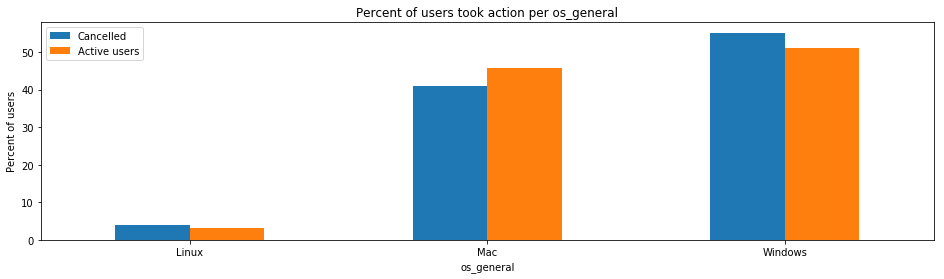

In [49]:
draw_time('os_general');

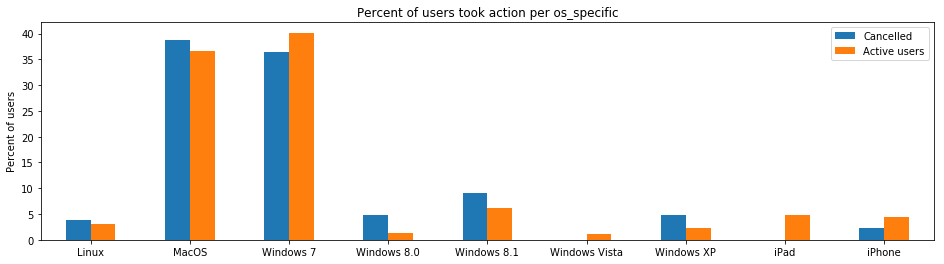

In [50]:
draw_time('os_specific');

9.在这里，没有取消用户的是iPad用户，随后是Windows Vista用户（但基数少）。大多数用户倾向于使用 MacOS Windows 7 Windows8 和 XP和Linux。这可能会引发一个关于用户使用的软件的问题，是不是和iPad和iPhone的软件一样好，让用户体验更好。

#### 2.用户州分布情况

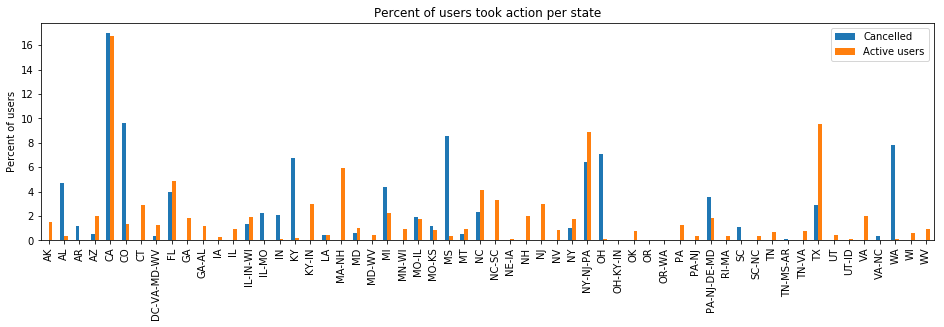

In [51]:
draw_time('state', label_rotation=90);

10.活跃用户和取消用户在各个州的分布情况，存在一定的差异性。

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### 总览
根据之前初步的探索性分析，初步判断以下两类数据字段需要保留在特征变量中：

1.分类变量 (需要通过get_dummy转化为数值型变量)

A.Gender of user/用户性别

B.The user's OS os_specific/用户系统

C.(may be) the state he/she lives in/用户所在州和市

D.The payment level (Paid/Free)/付费用户或免费用户

E.(may be) the top artist the user listined to./顶置艺术家

2.数值变量

A.Song length per user per session/一个场次歌曲时间长度

B.Number of ThumbsUp/喜欢数

C.Number of ThumbsDown/ 不喜欢数

D.Number of InviteFriends/邀请好友数

E.Number of downgrades/降级数

F.Number of songs per session/一个场次歌曲数量

G.Number of artists the user fans/艺术家的粉丝数

H.Session's duration/场次时间

I.Sessions' count per user/用户的场次数

J.The user's subscription age/用户注册时间

K.Number of days as free/paid user/用户作为免费或付费用户的天数

**第一步，我们应该创建一个churn/notchurn结果表，作为机器学习数据集的判断结果**

In [52]:
churn_users = df.select('userId', 'churn').dropDuplicates()

# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



**第二步，然后对分类变量进行Get Dummy Variable处理**

**1）Getting Dummy variable from the 'gender'**

In [53]:
def create_dummy_df (col, dictionary):
    '''
    Create a dataframe to map a variable
    col: the column name
    dictionary: the mapping of from->to numeric values
    return a dataframe of 2 columns
    '''
    # To map M and F to numeric values, we first should map to string numbers (to avoid spark error)
    col_df = df.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    # Then convert the result to numeric value
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check
    print(col_df.printSchema(), col_df.show(3))
    return col_df


gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows

None None


**2）Getting Dummy variables from a categoric value (the 'os_specific')**

reference:/42805663/e-num-get-dummies-in-pyspark

In [54]:
os_titles =  df.select('os_specific').distinct().rdd.flatMap(lambda x: x).collect()
os_expr = [sF.when(sF.col('os_specific') == osdt, 1).otherwise(0).alias("OS_" + osdt) for osdt in os_titles]
os_df = df.select('userId', *os_expr)
os_df.show(10)

+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|userId|OS_iPad|OS_iPhone|OS_Windows 8.1|OS_Linux|OS_Windows Vista|OS_Windows 8.0|OS_MacOS|OS_Windows XP|OS_Windows 7|
+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       

In [55]:
os_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- OS_iPad: integer (nullable = false)
 |-- OS_iPhone: integer (nullable = false)
 |-- OS_Windows 8.1: integer (nullable = false)
 |-- OS_Linux: integer (nullable = false)
 |-- OS_Windows Vista: integer (nullable = false)
 |-- OS_Windows 8.0: integer (nullable = false)
 |-- OS_MacOS: integer (nullable = false)
 |-- OS_Windows XP: integer (nullable = false)
 |-- OS_Windows 7: integer (nullable = false)



**3) Getting Dummy variable from the 'level'**

In [56]:
level_df = create_dummy_df('level', {'paid':'1', 'free':'0'})

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
+------+-----+
only showing top 3 rows

None None


**4）state 和 top_artists 在这一阶段暂不考虑，变量分布太多**

In [57]:
# Number of artists in the dataset
dfp.artist.unique().shape[0]

17656

**第三步，再对数值变量进行处处理**

**5）Song length per user per session (Get mean and StdDev per user)**

In [58]:
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(10)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878
5,7,1.509289,1.737257
6,54,5.645595,6.724164
7,15,9.470389,6.159368
8,155,9.202745,6.528672
9,100014,3.134420,1.754365


**6) Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, ...**

In [59]:
# To get the Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, ...
# I think it is better to get all actions except Chorn actions (Cancel, cancelation confirmation)
# The to normalize them as percent to sum all to 100.

# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1

# SOURCES
# https://stackoverflow.com/questions/47641076/spark-normalize-each-row-of-a-dataframe
# https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe

# the columns to be summed
pages_cols = user_page_distribution.columns[1:]

# Add a total column
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))

# Apply normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


**7) Number of songs per session**

In [60]:
# 2-F Number of songs per session

# number of changing songs
song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



**8) Number of artists the user fans**

In [61]:
# Number of artists the user fans
artists_user_fans = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(3)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
+------+----------+
only showing top 3 rows



**9)Session Duration**

In [62]:
# 2-G.1 Session Duration

session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [63]:
# 2-G.2  Get Average, and Standard deviation of the session duration per user

session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
+------+-------------------+------------------+
only showing top 3 rows



**10）Sessions count per user**

In [64]:
# 2-H Sessions count per user
num_sessions_user_df = df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



**11）The user's subscription days**

In [65]:
# 2-I The user's subscription age
def days_since_subscription(df, col_name='days_on'):
    # timestamp of users registration
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



**12）Number of days as free/paid user**

In [66]:
df_paid = df.filter(df.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(5)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
|    15|    56.513576388888886|
|    54|    110.75168981481481|
+------+----------------------+
only showing top 5 rows



In [67]:
df_free = df.filter(df.level=='free')
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show(5)

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
|     7|     72.77818287037037|
|    54|     96.45179398148149|
+------+----------------------+
only showing top 5 rows



In [68]:
paid_free_df = df.filter(df.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(10)

+------+------------------+-----------------+
|userId|      free_percent|     paid_percent|
+------+------------------+-----------------+
|200002| 22.48062015503876|77.51937984496125|
|100010|             100.0|              0.0|
|   125|             100.0|              0.0|
|     7|             100.0|              0.0|
|   124|               0.0|            100.0|
|    51|               0.0|            100.0|
|    54|15.452305526223162|84.54769447377683|
|    15|               0.0|            100.0|
|   155|12.317073170731707| 87.6829268292683|
|   132|1.4522821576763485|98.54771784232366|
+------+------------------+-----------------+
only showing top 10 rows



In [69]:
paid_free_df = paid_free_df.drop('free_percent')
paid_free_df.show(3)

+------+-----------------+
|userId|     paid_percent|
+------+-----------------+
|200002|77.51937984496125|
|100010|              0.0|
|   125|              0.0|
+------+-----------------+
only showing top 3 rows



**第四步，对所有特征进行整理和输出**

In [70]:
# the features to collect
user_features = [gender_df, os_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df, artists_user_fans, 
                   session_user_df, num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'os_df', 'paid_free_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                   'session_user_df', 'num_sessions_user_df', 'reg_df']

In [71]:
# Initialize the final_df
final_df = churn_users

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)
print('*** ALL DONE ***')

Preparing features of the gender_df dataframe; the new frame's dimensions is: 225 * 3
Preparing features of the os_df dataframe; the new frame's dimensions is: 225 * 12
Preparing features of the paid_free_df dataframe; the new frame's dimensions is: 225 * 13
Preparing features of the song_length dataframe; the new frame's dimensions is: 225 * 15
Preparing features of the user_page_distribution dataframe; the new frame's dimensions is: 225 * 32
Preparing features of the song_user_df dataframe; the new frame's dimensions is: 225 * 34
Preparing features of the artists_user_fans dataframe; the new frame's dimensions is: 225 * 35
Preparing features of the session_user_df dataframe; the new frame's dimensions is: 225 * 37
Preparing features of the num_sessions_user_df dataframe; the new frame's dimensions is: 225 * 38
Preparing features of the reg_df dataframe; the new frame's dimensions is: 225 * 39
*** ALL DONE ***


In [74]:
# Saving as SPARK format, run only once
final_df.write.save('saved_user_dataset.CSV', format='csv', header=True)

In [70]:
final_dfp = final_df.toPandas()
final_dfp.head(10)

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,10,0,1,0,0,0,0,0,0,1,...,0.503145,4.654088,0.000000,112.166667,133.324291,566,7.662454,8.991061,6,51.762650
1,100,0,1,0,0,0,0,0,0,0,...,0.840075,4.604854,0.031114,78.882353,74.057621,1706,5.275317,5.133618,35,64.873773
2,100001,1,0,0,0,0,0,0,0,1,...,1.081081,4.324324,1.081081,33.250000,16.839933,126,2.469306,1.051126,4,44.800220
3,100002,0,0,0,0,0,0,0,0,0,...,0.000000,2.293578,0.000000,48.750000,84.428964,185,3.353056,5.901765,4,160.472072
4,100003,1,0,0,0,0,0,0,0,0,...,0.000000,3.947368,0.000000,25.500000,33.234019,51,1.651944,2.260385,2,22.748113
5,100004,0,0,0,0,0,0,0,0,0,...,0.883534,2.811245,0.642570,47.100000,55.459706,734,3.099775,3.895202,21,172.440081
6,100005,1,1,0,0,0,0,0,0,1,...,1.401869,3.271028,1.869159,38.500000,13.771952,150,2.003111,1.367039,5,85.195590
7,100006,1,0,0,0,1,0,0,0,0,...,4.761905,4.761905,0.000000,26.000000,0.000000,27,1.557222,0.000000,1,9.127164
8,100007,1,0,0,0,1,0,0,0,0,...,1.158301,3.667954,0.000000,47.000000,55.366958,358,3.156852,3.789902,9,115.387616
9,100008,0,0,0,0,0,0,0,0,1,...,0.638298,3.936170,0.425532,128.666667,182.128160,624,8.804213,12.541217,6,68.228565


In [71]:
final_dfp.to_csv('saved_user_dataset_pd.CSV', index=False)

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

**第一步，导入、调整和标准化数据**

In [72]:
final_df = spark.read.csv('saved_user_dataset.CSV', header = True)
pfinal_df = final_df.toPandas()
pfinal_df.head()

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,30,0,1,0,0,0,0,0,0,0,...,0.9577464788732395,3.492957746478873,0.7887323943661971,50.607142857142854,68.92579976333879,1019,3.0599045138888887,4.655638231407505,32,63.06664351851852
1,300001,1,0,0,0,0,0,0,0,0,...,0.7848568790397045,6.832871652816251,0.09233610341643582,102.88235294117646,88.12908313444346,1202,6.367543859649123,6.150871757879998,19,188.3117824074074
2,91,0,1,0,0,1,0,0,0,0,...,0.7962840079628402,4.11413404114134,0.033178500331785,286.6666666666667,337.84426885770904,1619,19.665,23.019357929090734,9,116.02526620370371
3,92,0,0,1,0,0,0,0,0,0,...,0.9958506224066389,4.0387275242047025,0.06915629322268327,70.77380952380952,86.9796197137792,2905,4.745203488372092,6.054084867345142,86,83.52885416666666
4,200008,0,0,0,0,0,0,0,0,0,...,2.584493041749503,3.3797216699801194,0.049701789264413515,111.26666666666667,107.38613016763829,1160,7.5379259259259275,7.284556907097743,15,115.18381944444444


In [73]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- OS_iPad: string (nullable = true)
 |-- OS_iPhone: string (nullable = true)
 |-- OS_Windows 8.1: string (nullable = true)
 |-- OS_Linux: string (nullable = true)
 |-- OS_Windows Vista: string (nullable = true)
 |-- OS_Windows 8.0: string (nullable = true)
 |-- OS_MacOS: string (nullable = true)
 |-- OS_Windows XP: string (nullable = true)
 |-- OS_Windows 7: string (nullable = true)
 |-- paid_percent: string (nullable = true)
 |-- mean_hours: string (nullable = true)
 |-- stdev_hours: string (nullable = true)
 |-- About: string (nullable = true)
 |-- Add Friend: string (nullable = true)
 |-- Add to Playlist: string (nullable = true)
 |-- Downgrade: string (nullable = true)
 |-- Error: string (nullable = true)
 |-- Help: string (nullable = true)
 |-- Home: string (nullable = true)
 |-- Logout: string (nullable = true)
 |-- NextSong: string (nullable = true)
 |-- Roll 

In [74]:
# Change the column names to strings without spaces
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(final_df.columns)

['userId', 'churn', 'gender', 'OS_iPad', 'OS_iPhone', 'OS_Windows_81', 'OS_Linux', 'OS_Windows_Vista', 'OS_Windows_80', 'OS_MacOS', 'OS_Windows_XP', 'OS_Windows_7', 'paid_percent', 'mean_hours', 'stdev_hours', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'num_aritst', 'mean_session_h', 'stdev_session_h', 'num_sessions', 'days_total_subscription']


In [75]:
# Convert all to numbers as the schema shows strings
# the first column (userId) would be integer
final_df = final_df.withColumn('userId', final_df.userId.cast(sT.IntegerType()))
# All columns from Churn to OS_* should be integer types
for col in final_df.columns[1:12]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.IntegerType()))
# All other columns should be float
for col in final_df.columns[12:]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.FloatType()))

final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- OS_iPad: integer (nullable = true)
 |-- OS_iPhone: integer (nullable = true)
 |-- OS_Windows_81: integer (nullable = true)
 |-- OS_Linux: integer (nullable = true)
 |-- OS_Windows_Vista: integer (nullable = true)
 |-- OS_Windows_80: integer (nullable = true)
 |-- OS_MacOS: integer (nullable = true)
 |-- OS_Windows_XP: integer (nullable = true)
 |-- OS_Windows_7: integer (nullable = true)
 |-- paid_percent: float (nullable = true)
 |-- mean_hours: float (nullable = true)
 |-- stdev_hours: float (nullable = true)
 |-- About: float (nullable = true)
 |-- Add_Friend: float (nullable = true)
 |-- Add_to_Playlist: float (nullable = true)
 |-- Downgrade: float (nullable = true)
 |-- Error: float (nullable = true)
 |-- Help: float (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll_Ad

In [76]:
# Remove  nulls from anywhere replacing them by zeros
final_df = final_df.na.fill(0)

In [77]:
# Get features labels for plotting purposes
features_labels = final_df.columns[2:]

In [78]:
# The input features are all but the userId and the Churn
# The output is Churn only

# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')

# Apply the vectorization on the dataset
input_data = features_vector.transform(final_df)
# input_data.show(1)

In [79]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [80]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [81]:
# Defining training and testing samples
train, test = ml_data.randomSplit([0.80, 0.20], seed=179)
# train.show(3), test.show(3)

**第二步，定义重要功能、模型和输出分析**

In [82]:
def format_duration (t_dif):
    t_s = t_dif.seconds
    duration = {}
    duration['h'], rem = divmod(t_s, 3600) 
    duration['m'], duration['s'] = divmod(rem, 60)
    stamp = ''
    if duration['h']>0:
        stamp += f"{duration['h']} hour(s), " 
    if duration['m']>0:
        stamp += f"{duration['m']} minute(s) and "
    # seconds and fraction of seconds
    frac = int(t_dif.microseconds/10000)/100
    stamp += f"{duration['s'] + frac} second(s)"
    # print(f"{duration['h']}h:{duration['m']}m:{duration['s']}s")
    return stamp

In [83]:
def model_fitting(data, model_type, param_grid, save_as, num_folds=3, random_seed=179):
    '''
    
    
    '''
    model_evaluator = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=num_folds, seed=random_seed)
    t_start = pd.tslib.Timestamp.now()
    print ('Fitting in progress...', end=' ')
    fitted_model = model_evaluator.fit(data)
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    t_start = pd.tslib.Timestamp.now()
    print (f'\nSaving the model as {save_as}...' , end=' ')
    try:
        fitted_model.save(save_as)
    except:
        # Overwrite if exists
        fitted_model.write().overwrite().save(save_as)
        print ('*Overwritten* ', end='')
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    return fitted_model

In [84]:
def get_formated_metrics(selected_model, test_data):
    '''
    Prints a compacted dataframe with all the model's metrics
    selected_model: The fitted model
    test_data: the test data portion
    '''
    def get_model_metrics(selected_model, model_type = 'train'):
        '''
        Get the metrics of a model
        selected_model:  the fitted model
        model_type: either 'train' (default) or 'test'
        '''
        if model_type == 'train':
            metrics = selected_model.bestModel.summary
        else: 
            metrics = selected_model
        acc = metrics.accuracy, 
        general = np.array((metrics.weightedFMeasure(),
                   metrics.weightedPrecision, metrics.weightedRecall,
                   metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate))
        general = general.reshape(1, general.shape[0])
        labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
        labeled = np.array((metrics.fMeasureByLabel(),
                          metrics.precisionByLabel, metrics.recallByLabel,
                          metrics.truePositiveRateByLabel, metrics.falsePositiveRateByLabel))
        conc_results = np.concatenate((general.T, labeled), axis=1)
        metrics_names = ['F-Measure', 'Precision', 'Recall', 'True_+ve_Rate', 'False_+ve_Rate']
        df_res = pd.DataFrame(conc_results, columns=labels, index=metrics_names)
        return acc[0], df_res
    
    # Apply for training data
    acc_train, train_res = get_model_metrics(selected_model)
    # Get the results of the test data
    model_test = selected_model.bestModel.evaluate(test_data)
    # Apply on test data
    acc_test, test_res = get_model_metrics(model_test, model_type='test')
    
    # Concatenate to a pretty dataframe
    pretty_frame = pd.concat([train_res, test_res], axis=1, keys=[
                    f'Training (Accuracy = {acc_train*100:4.2f}%)',
                    f'Testing (Accuracy = {acc_test*100:4.2f}%)'])
    return pretty_frame

In [85]:
def draw_features_contribution(fitted_model, x_labels, scale_to='full_range'):
    '''
    Draws a bar chart of features vs churn %
    fitted_model: the fitted model
    scale_to: the values will be scated to:
           'full_range' where the full absolute values are summed to 100.
           'maximum_range' where the maximum absolute extremes are scalled to 100.
           'none' the values are shown as is.
    '''
    cmx = fitted_model.bestModel.coefficientMatrix
    cmv = cmx.values
    # cmv.shape, len(final_df.columns[2:])
    
    # Define positive and negative values
    positives_v = np.array([x if x>=0 else 0 for x in cmv])
    negatives_v = np.array([x if x<=0 else 0 for x in cmv])    
    
    # Drawing by scalling the maximum range to  100
    if scale_to == 'full_range':
        rang = positives_v.sum()+ abs(negatives_v).sum()
    elif scale_to == 'maximum_range':
        rang = positives_v.max()+ abs(negatives_v).max()
    else:
        rang = 1.
        
    positives_v /= rang
    negatives_v /= rang
    positives_v *= 100.
    negatives_v *= 100.
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(x_labels, positives_v,color='r')
    ax.bar(x_labels, negatives_v, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('The user is most likely to churn (%)')
    ax.set_title('Contribution of each feature to the churn decission')
    ax.set_xticklabels(labels = final_df.columns[2:], rotation='vertical');

In [86]:
def get_classifier_metrics(trained_model, train_data, test_data):
    '''
    
    '''
    def get_specific_metrics(trained_model, data):
        '''
        
        '''
        res2 = trained_model.transform(data).select('label', 'prediction')
        TruePos = res2.filter((res2.prediction==1)& (res2.label == res2.prediction) ).count()
        TrueNeg = res2.filter((res2.prediction==0)& (res2.label == res2.prediction) ).count()
        FalsPos = res2.filter((res2.prediction==1)& (res2.label != res2.prediction) ).count()
        FalsNeg = res2.filter((res2.prediction==0)& (res2.label != res2.prediction) ).count()
        accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = TruePos/(TruePos+FalsPos)
        recall = TruePos/(TruePos+FalsNeg)
        f1score = 2 * precision * recall / (precision + recall)
        
        return accuracy, precision, recall, f1score
    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels =['Train', 'Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

备注：在get_classifier_metrics模块中，CrossValidator使用3次折叠，将生成3个（训练，测试）数据集对，每个对都使用2/3的数据进行训练，并使用1/3的数据进行验证。当数据集比较小的时候交叉验证可以“充分利用”有用的数据找到合适的模型参数，防止过度拟合。但当数据集比较大的时候，会使得整个数据集的训练过程比较漫长。

In [87]:
def draw_features_importance(fitted_model, x_labels, threshold=0.1):
    '''
    Draws a pie chart of features
    fitted_model: the fitted model
    x_labels: the labels of the features.
    threshold: the minimum value (%) to consider, 
               if the value is less than that, 
               it will be neglected (default =0)
    '''
    importance = list(fitted_model.bestModel.featureImportances.toArray())
    # Get the threshold value
    thres_v = threshold / 100 
    # get the included and neglected values
    active_values = [x for x in importance if x >= thres_v]
    neglected = [x for x in importance if x < thres_v]
    non_zero_neglected = [x for x in neglected if x > 0]
    # print(importance, '\n', x_labels, '\n', thres_v, '\n', 
    #       active_values, '\n', neglected, '\n', non_zero_neglected)
    # get the accepted indexes
    active_idx = [importance.index(x) for x in active_values]
    # the accepted lables + minor features
    active_labels = [x_labels[x] for x in active_idx]
    minor_v = sum(neglected)
    # print(active_idx, '\n', active_labels, '\n', minor_v)
    # If there is any minor features
    if minor_v>0:
        active_values.append(minor_v)
        active_labels.append(f'MINOR, ({len( \
                non_zero_neglected)}feats. each<{threshold}%)')
    # print(active_labels, '\n', active_values)
    
    # sorting
    active_labels =[x for _, x in sorted(zip(active_values, active_labels))]
    active_values = sorted(active_values)
    
    # Draw

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(active_values[::-1], labels=active_labels[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90 )
    ax.set_title('Importance of each feature to the churn decission')
    ax.axis('equal');

**模型1.The Logistic Regression model**

Fitting in progress... Done in 1 minute(s) and 52.9 second(s)

Saving the model as LogisticRegression.model... *Overwritten* Done in 0.58 second(s)


Training (Accuracy = 82.49%)                      \
                                    General Churn=0.0 Churn=1.0   
F-Measure                          0.801271  0.895623  0.456140   
Precision                          0.807945  0.841772  0.684211   
Recall                             0.824859  0.956835  0.342105   
True_+ve_Rate                      0.824859  0.956835  0.342105   
False_+ve_Rate                     0.525919  0.657895  0.043165   

               Testing (Accuracy = 77.08%)                      
                                   General Churn=0.0 Churn=1.0  
F-Measure                         0.743333  0.853333  0.476190  
Precision                         0.761179  0.780488  0.714286  
Recall                            0.770833  0.941176  0.357143  
True_+ve_Rate                     0.770833  0.941176  0.357143  
False_+ve_Rate                    0.472514  0.642857  0.058824

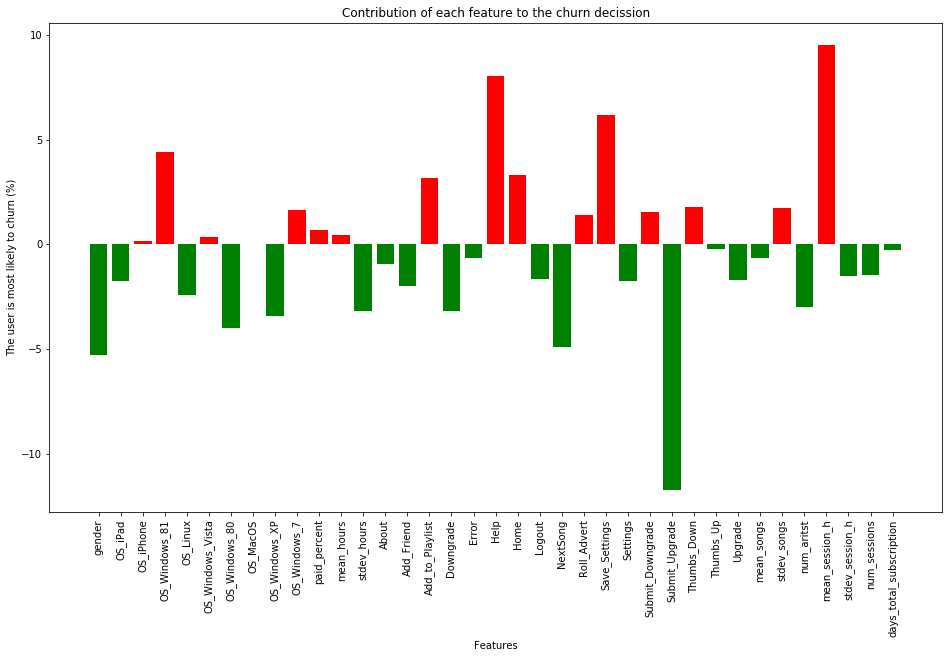

In [89]:
# The Logistic Regression model

model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()
# param_grid = ParamGridBuilder() \
#     .addGrid(model.aggregationDepth,[2, 5]) \
#     .build()
m = model_fitting(train, model, param_grid, 'LogisticRegression.model')
# Model metrics
display(get_formated_metrics(m, test))
# Features effect
draw_features_contribution(m, x_labels=features_labels)

**模型2.The Decision Tree Classifier model**

In [90]:
# The Decision Tree Classifier model

model = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .build()

m = model_fitting(train, model, param_grid, 'DecisionTreeClassifier.model')

Fitting in progress... Done in 31.16 second(s)

Saving the model as DecisionTreeClassifier.model... *Overwritten* Done in 0.73 second(s)


In [90]:
features_labels = ['gender', 'OS_iPad', 'OS_iPhone', 'OS_Windows_81', 
                   'OS_Linux', 'OS_Windows_Vista', 'OS_Windows_80', 
                   'OS_MacOS', 'OS_Windows_XP', 'OS_Windows_7', 
                   'paid_percent', 'mean_hours', 'stdev_hours', 
                   'About', 'Add_Friend', 'Add_to_Playlist', 
                   'Downgrade', 'Error', 'Help', 'Home', 'Logout', 
                   'NextSong', 'Roll_Advert', 'Save_Settings', 
                   'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 
                   'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 
                   'stdev_songs', 'num_aritst', 'mean_session_h', 
                   'stdev_session_h', 'num_sessions', 
                   'days_total_subscription']
len(features_labels)

37

In [91]:
# to load the model from saved location
m = mlm.load('DecisionTreeClassifier.model') 

In [92]:
get_classifier_metrics(m, train, test)

,Train,Test
Accuracy,0.903955,0.812500
Precision,0.838710,0.727273
Recall,0.684211,0.571429
F-Score,0.753623,0.640000


In [93]:
predictions=m.transform(test)
predictions.columns

['label', 'features', 'rawPrediction', 'probability', 'prediction']

In [94]:
evaluator=BinaryClassificationEvaluator(
                rawPredictionCol='rawPrediction',
                labelCol='label',
                metricName='areaUnderROC')
auc=evaluator.evaluate(predictions)
auc

0.7300420168067226

reference:https://www.jianshu.com/p/5a9a7bc8aa60

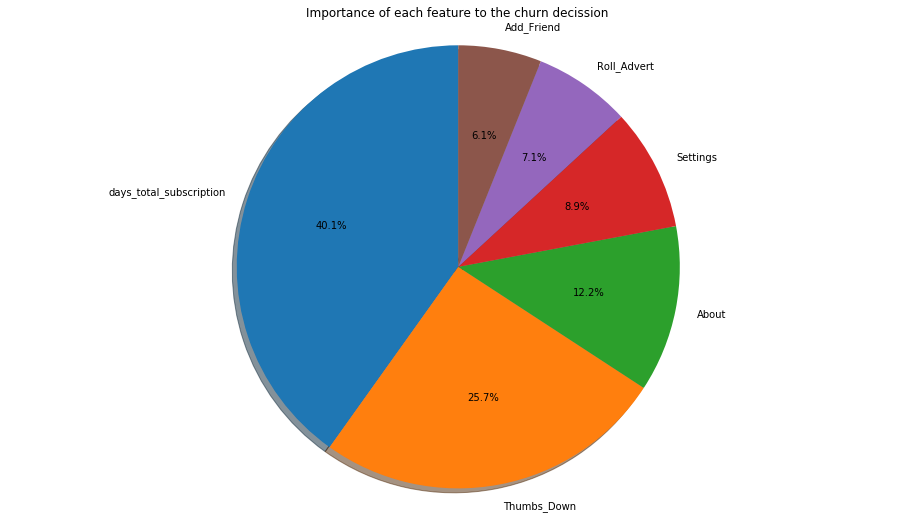

In [95]:
draw_features_importance(m, features_labels, threshold=3)

**模型3.The Gradient-Boosted Trees (GBTs) model**

In [96]:
# The Gradient-Boosted Trees (GBTs) model
model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.maxIter ,[20, 5]) \
    .build()

m = model_fitting(train, model, param_grid, 'GradientBoostedTrees.model')

Fitting in progress... Done in 6 minute(s) and 5.65 second(s)

Saving the model as GradientBoostedTrees.model... *Overwritten* Done in 1.23 second(s)


In [97]:
# to load the model from saved location
m = mlm.load('GradientBoostedTrees.model') 

In [99]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.943503,0.770833
Precision,1.000000,0.666667
Recall,0.736842,0.428571
F-Score,0.848485,0.521739


In [100]:
predictions=m.transform(test)
predictions.columns

['label', 'features', 'rawPrediction', 'probability', 'prediction']

In [101]:
auc=evaluator.evaluate(predictions)
auc

0.7394957983193278

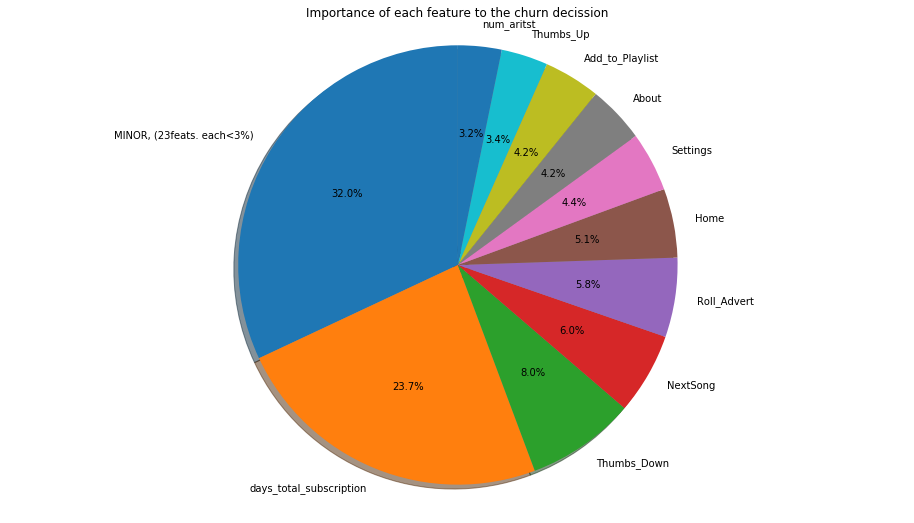

In [110]:
draw_features_importance(m, features_labels, threshold=3)

**模型4.The Random Forest model**

In [111]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.numTrees ,[20, 10]) \
    .addGrid(model.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

m = model_fitting(train, model, param_grid, 'RandomForestClassifier.model')

Fitting in progress... Done in 2 minute(s) and 25.35 second(s)

Saving the model as RandomForestClassifier.model... *Overwritten* Done in 1.09 second(s)


In [112]:
# to load the model from saved location
m = mlm.load('RandomForestClassifier.model') 

In [107]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.943503,0.812500
Precision,1.000000,0.777778
Recall,0.736842,0.500000
F-Score,0.848485,0.608696


In [108]:
predictions=m.transform(test)
predictions.columns

['label', 'features', 'rawPrediction', 'probability', 'prediction']

In [109]:
auc=evaluator.evaluate(predictions)
auc

0.6974789915966386

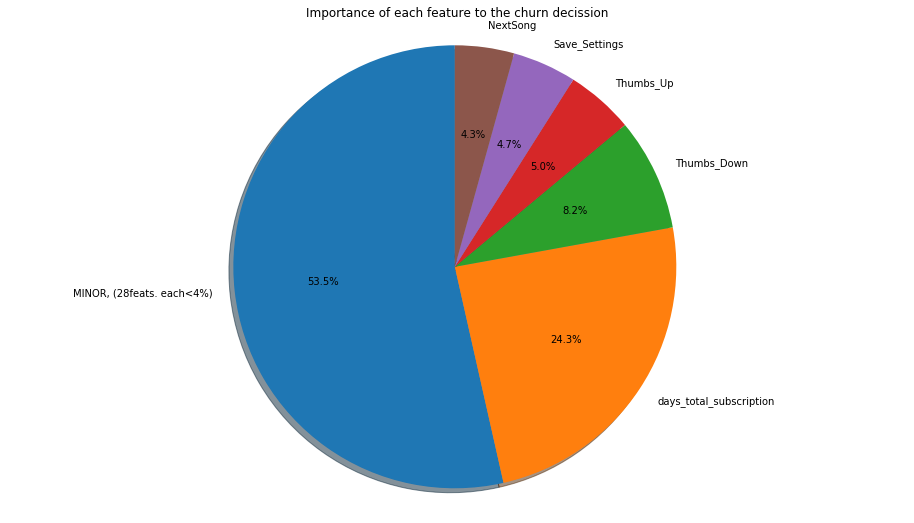

In [110]:
draw_features_importance(m, features_labels, threshold=4)

**模型5.The Multilayer Perceptron Classifier model**

In [113]:
# The Multilayer Perceptron Classifier model
model = MultilayerPerceptronClassifier()

param_grid = ParamGridBuilder() \
    .addGrid(model.blockSize,[64, 128]) \
    .addGrid(model.maxIter,[10, 20]) \
    .addGrid(model.stepSize ,[0.03, 0.01]) \
    .addGrid(model.solver ,['l-bfgs', 'gd']) \
    .addGrid(model.layers, [[37, 12, 2], [37, 5, 2]]) \
    .build()

m = model_fitting(train, model, param_grid, 'MultilayerPerceptronClassifier.model')

Fitting in progress... Done in 2 minute(s) and 30.89 second(s)

Saving the model as MultilayerPerceptronClassifier.model... *Overwritten* Done in 0.94 second(s)


In [114]:
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.757062,0.791667
Precision,0.419355,0.700000
Recall,0.342105,0.500000
F-Score,0.376812,0.583333


In [115]:
predictions=m.transform(test)
auc=evaluator.evaluate(predictions)
auc

0.7289915966386554

*备注：由于Multilayer Perceptron Classifier model，没有featureimportance的输出，因此此处无法展示各特征变量的重要性占比*

**模型6.The NaiveBayes model：特征变量中含有负值，因此该模型在此处不适用**

### 模型的评价与验证

1.模型基本合理，与期待的结果相接近，F1分数在0.5左右，AUC>0.7；但没有超过预期

2.经过不同样本量的训练，训练数据一些微小的改变应该没有造成极大影响结果

3.根据以上的评价分数和基本稳定的模型表现，该模型基本合格

### 结果
1.训练数据属于不平衡数据，约有25%的用户属于取消订阅用户，因此F1分数和AUC比单纯的Acurracy和Recall有更高的参考价值

2.模型的预测分数比较低，这可能是因为目前没有使用地区和更多的特征，以及训练的数据量有限导致

3.训练后的模型基本稳健，符合鲁棒性原则。一方面多个模型训练出的结果基本接近，另一方面模型也进行了最优化处理

4.模型存在过拟合的情况，训练集和测试集的F1值存在一定的差异性

**第三步，生成分析应用和使用展示**

**已将重要函数和功能已集成到generalipsparkify.py中，因此该分析可以应用于不同云端的数据分析和应用。**

**以下为使用介绍：**

In [42]:
from GeneralizeSparkify import load_clean_transfer

3.1. 加载提取的数据new_data_extraction.CSV

In [ ]:
ml_ds = load_ml_dataset(saved_as='new_data_extraction.CSV')

3.2 获取训练、测试数据集和特征变量名称

In [ ]:
train, test, features_labels = get_train_test_features(ml_ds)

3.3.1对数据应用机器学习模型和创建模型：

In [ ]:
apply_model(train, test, features_labels, model_name='GBT',save_as='NewGBT.model')

3.3.2或者直接使用已存在的模型：

In [ ]:
apply_model(train, test, features_labels,model_name='LR', load_from_existing='LogisticRegression.model')

## 结论

### A.初步结果：

**经过数据的清洗，特征工程和模型训练，机器学习模型能够成功地预测了最有可能退订/取消使用的客户；并能够展示相应特征的权重**

**除朴素贝叶斯模型，其它模型都取得了一定的效果，目前决策树分类器模型似乎是最好的。其他模型可以使用不同的设置重新调整，以减少过度拟合。**

**作为参考基准的逻辑回归模型可能由于一定的共线性问题，要比决策树类的模型预测效果要差一些**

### B.进一步的改进思考

**尽管目前的实施取得了良好的成果，但仍有可能通过以下一项或多项措施来改进成果：**

**1.通过增加数据集大小来处理更多的观察结果（通过使用12GB的完整数据集是可能,但需要更多的时间和算力）**

**2.尝试选定模型的更多参数。**

**3.添加一些我认为必不可少的功能，比如客户位置（城市/州）；地域使用情况存在一定差异**

### C.最具挑战性部分

**pyspark使用和实现，和python语言的使用熟练程度还存在很大差距，需要进一步的联系和实践**

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。